In [2]:
import sys
sys.version

import exoplanet
print(f"exoplanet.__version__ = '{exoplanet.__version__}'")



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx
from astropy import units as u
from astropy.constants import M_earth, M_sun
from simulate import *
from model import *
import pickle # python3


import matplotlib 
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18)



exoplanet.__version__ = '0.5.1'


/Users/Danielyahalomi/Documents/Columbia/Research/RomanAstrometry/Code/simulate.py:349: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/Danielyahalomi/Documents/Columbia/Research/RomanAstrometry/Code/simulate.py:419: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/Danielyahalomi/Documents/Columbia/Research/RomanAstrometry/Code/simulate.py:440: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


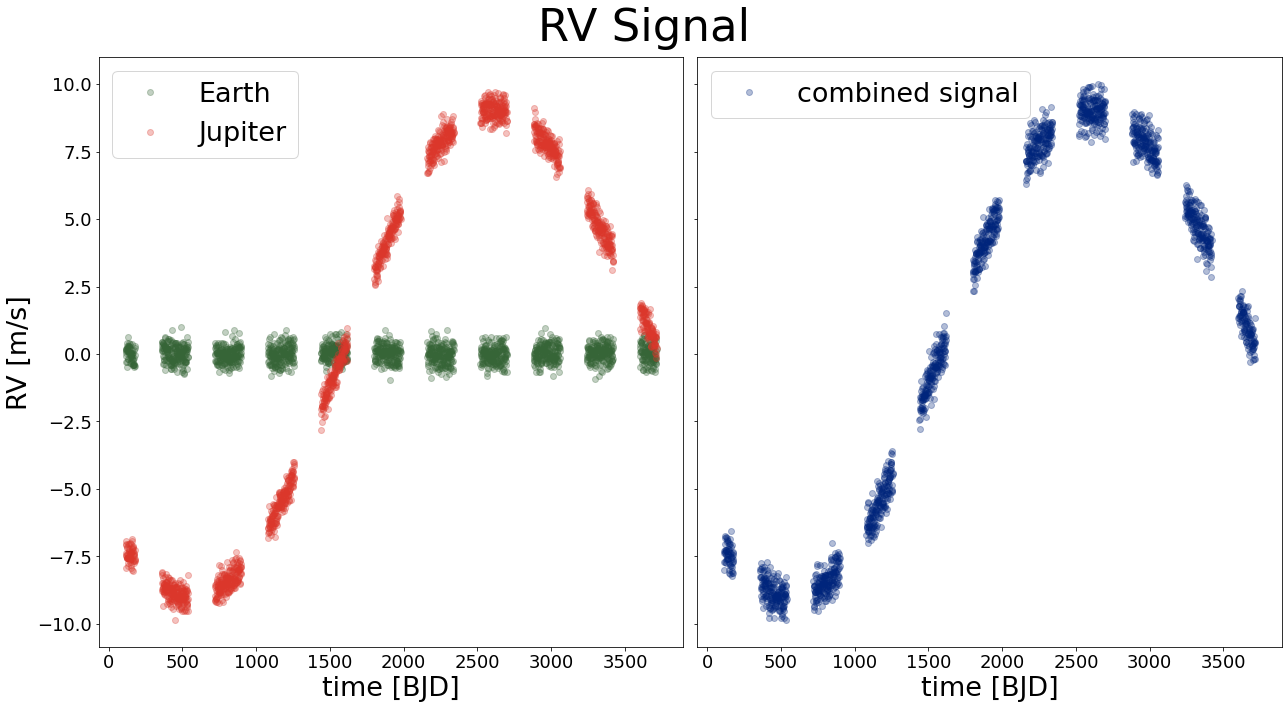

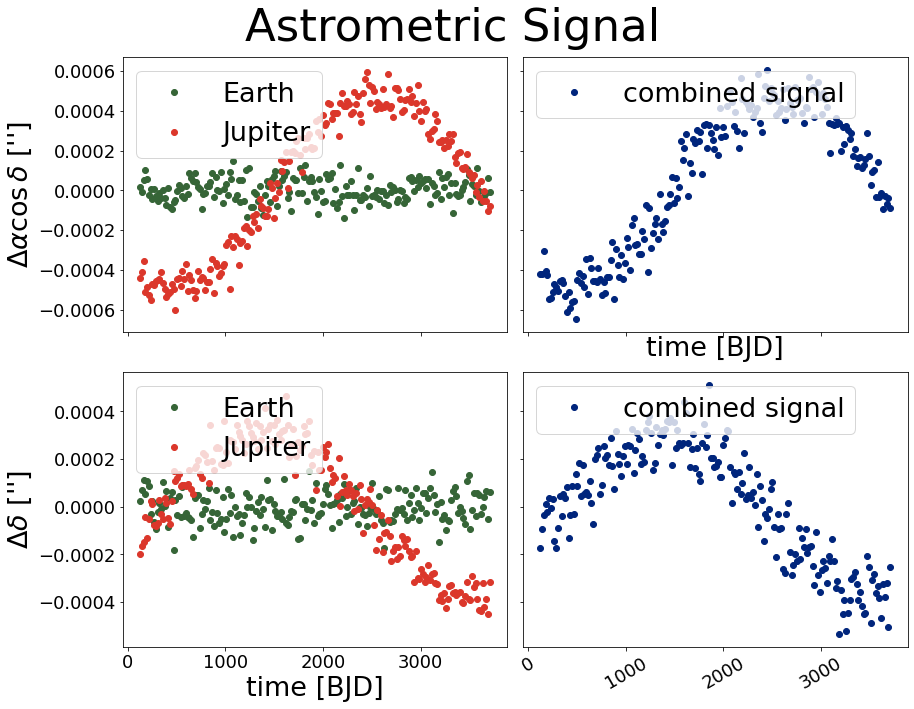

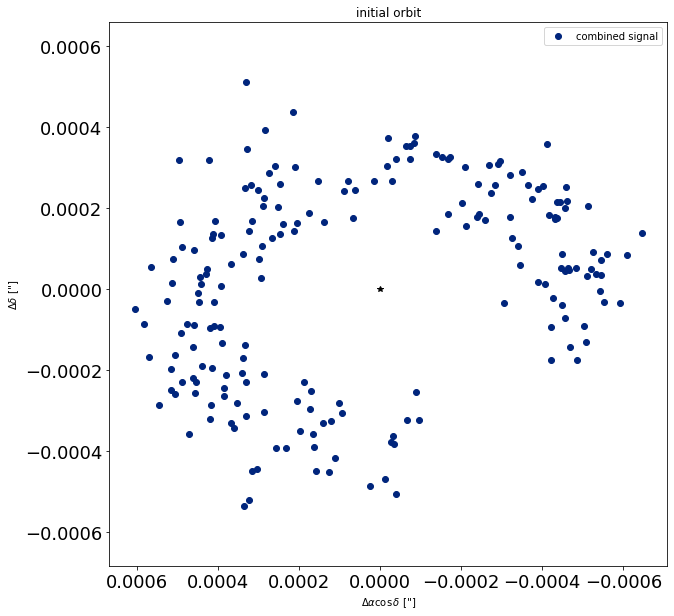

In [3]:
T_subtract = 2454000
# orbital parameters from https://www.princeton.edu/~willman/planetary_systems/Sol/
# BJD determined by converting values above using https://ssd.jpl.nasa.gov/tc.cgi#top

P_earth = 300
e_earth = 0.0167
Tper_earth= 2454115.5208333 - T_subtract
omega_earth = np.radians(102.9)
Omega_earth = np.radians(0.0)
inclination_earth = np.radians(45.0)
m_earth = 1*3.00273e-6 #units m_sun



P_jup = 4327
e_jup = 0.0484
Tper_jup = 2455633.7215278 - T_subtract
omega_jup = np.radians(274.3) - 2*np.pi
Omega_jup = np.radians(100.4)
inclination_jup = np.radians(1.31) + inclination_earth
m_jup = 317.83*3.00273e-6 #units m_sun


m_sun = 333030 #earth masses


times_observed_astrometry_gaia = []
t_0 = int(Tper_earth)
for ii in range(t_0, t_0+3600):
    if ii % (3600/200) == 0:
        times_observed_astrometry_gaia.append(ii)

t_1 =  times_observed_astrometry_gaia[-1]+1800
times_observed_astrometry_roman = []
for ii in range(t_1, t_1+3600):
    if ii % 90 == 0:
        times_observed_astrometry_roman.append(ii)    

        
times_observed_rv = []
t_0 = int(Tper_earth)
add_data = True
for ii in range(t_0, t_0+3600):
    
    if ii % 180 == 0:
        if add_data:
            add_data = False
        else:
            add_data = True
       
    if add_data:
        times_observed_rv.append(ii)
        

orbit_params_earth = [P_earth, e_earth, Tper_earth, omega_earth, Omega_earth, inclination_earth, m_earth]
orbit_params_jup = [P_jup, e_jup, Tper_jup, omega_jup, Omega_jup, inclination_jup, m_jup]

n_planets = 2
orbit_params = [orbit_params_earth, orbit_params_jup]


sigma_rv = 0.3

sigma_ra = 6e-5
sigma_dec = 6e-5
parallax = 0.1



times, rv_results, ra_results, dec_results = simulate_and_plot(
    n_planets, 
    sigma_rv, 
    sigma_ra,
    sigma_dec,
    parallax,
    orbit_params,
    ['#366537', '#db372b', '#00257c'],
    ['Earth', 'Jupiter'],
    times_observed_rv = times_observed_rv,
    times_observed_astrometry = times_observed_astrometry_gaia
    )


[[times_rv, times_observed_rv, times_astrometry, times_observed_astrometry],
[rv_orbit, rv_orbit_sum, rv_sim, rv_sim_sum],
[ra_orbit, ra_orbit_sum, ra_sim, ra_sim_sum],
[dec_orbit, dec_orbit_sum, dec_sim, dec_sim_sum]]  = times, rv_results, ra_results, dec_results



/Users/Danielyahalomi/Documents/Columbia/Research/RomanAstrometry/Code/simulate.py:349: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/Danielyahalomi/Documents/Columbia/Research/RomanAstrometry/Code/simulate.py:419: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/Danielyahalomi/Documents/Columbia/Research/RomanAstrometry/Code/simulate.py:440: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


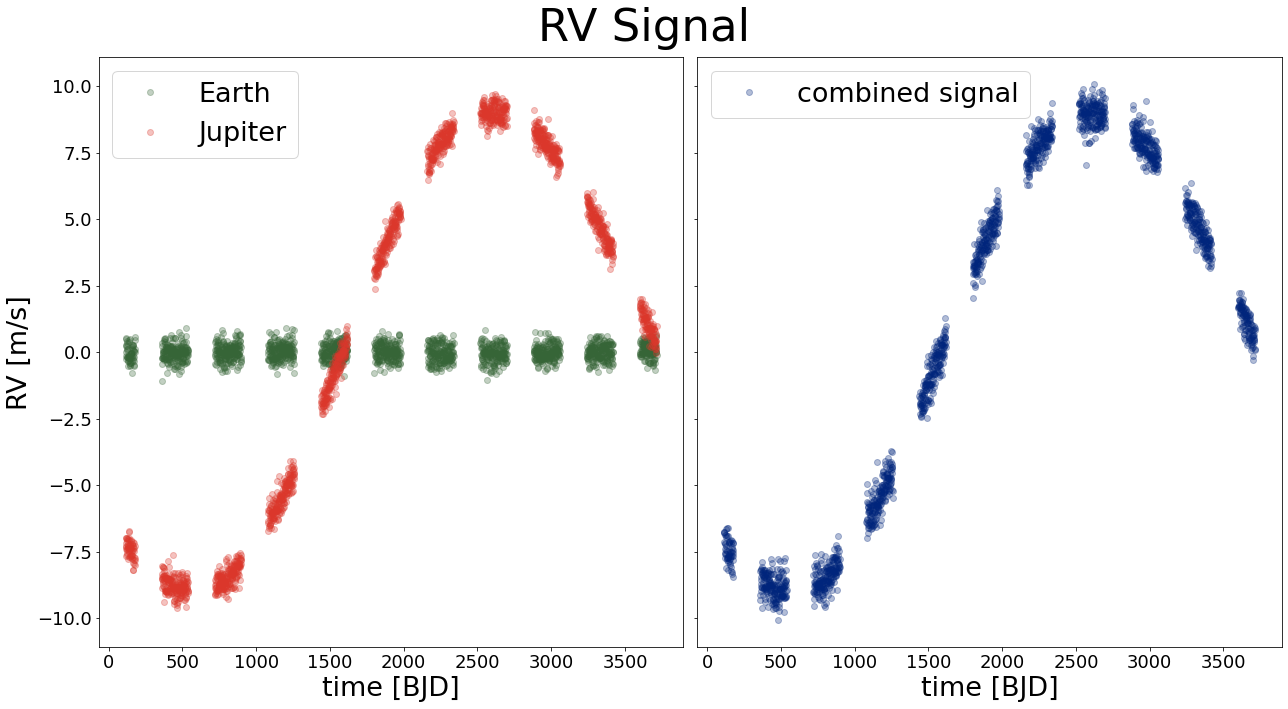

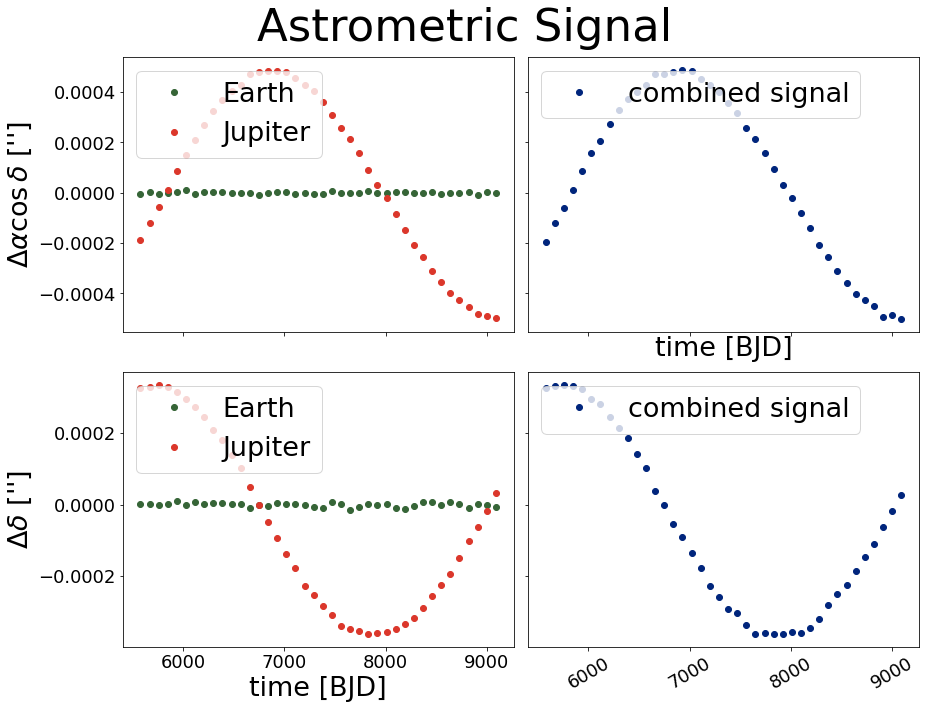

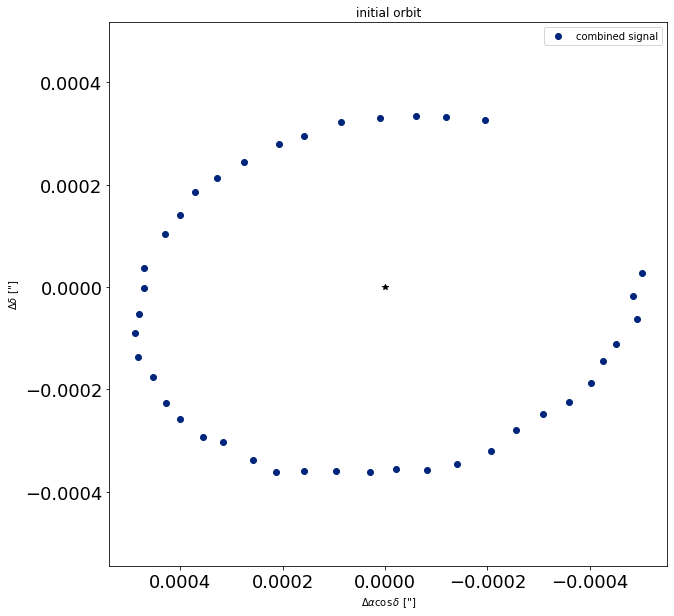

In [4]:
orbit_params_earth = [P_earth, e_earth, Tper_earth, omega_earth, Omega_earth, inclination_earth, m_earth]
orbit_params_jup = [P_jup, e_jup, Tper_jup, omega_jup, Omega_jup, inclination_jup, m_jup]

n_planets = 2
orbit_params = [orbit_params_earth, orbit_params_jup]


sigma_rv = 0.3

sigma_ra = 5e-6
sigma_dec = 5e-6
parallax = 0.1



times, rv_results, ra_results, dec_results = simulate_and_plot(
    n_planets, 
    sigma_rv, 
    sigma_ra,
    sigma_dec,
    parallax,
    orbit_params,
    ['#366537', '#db372b', '#00257c'],
    ['Earth', 'Jupiter'],
    times_observed_rv = times_observed_rv,
    times_observed_astrometry = times_observed_astrometry_roman
    )

#mask_start = len(times_astrometry)
times_astrometry = np.append(times_astrometry, times[2], axis=0)
#times_astrometry[mask_start] = np.ma.masked

times_observed_astrometry = np.append(times_observed_astrometry, times[3], axis=0)

ra_orbit = np.append(ra_orbit, ra_results[0], axis=0)
ra_orbit_sum = np.append(ra_orbit_sum, ra_results[1], axis=0)
ra_sim = np.append(ra_sim, ra_results[2], axis=0)
ra_sim_sum = np.append(ra_sim_sum, ra_results[3], axis=0)

dec_orbit = np.append(dec_orbit, dec_results[0], axis=0)
dec_orbit_sum = np.append(dec_orbit_sum, dec_results[1], axis=0)
dec_sim = np.append(dec_sim, dec_results[2], axis=0)
dec_sim_sum = np.append(dec_sim_sum, dec_results[3], axis=0)



/Users/Danielyahalomi/Documents/Columbia/Research/RomanAstrometry/Code/simulate.py:419: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/Danielyahalomi/Documents/Columbia/Research/RomanAstrometry/Code/simulate.py:440: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


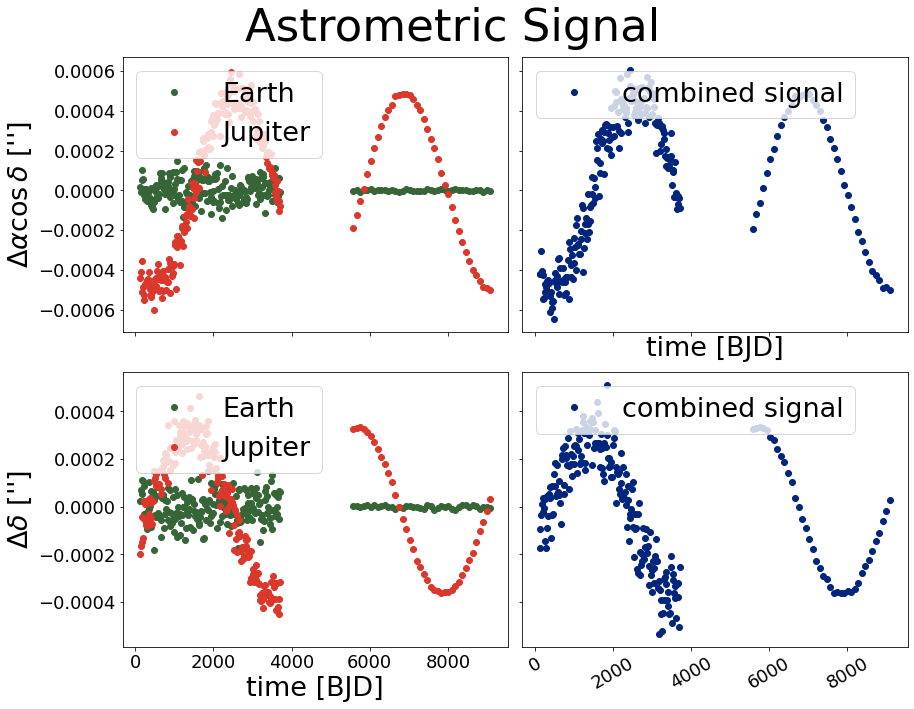

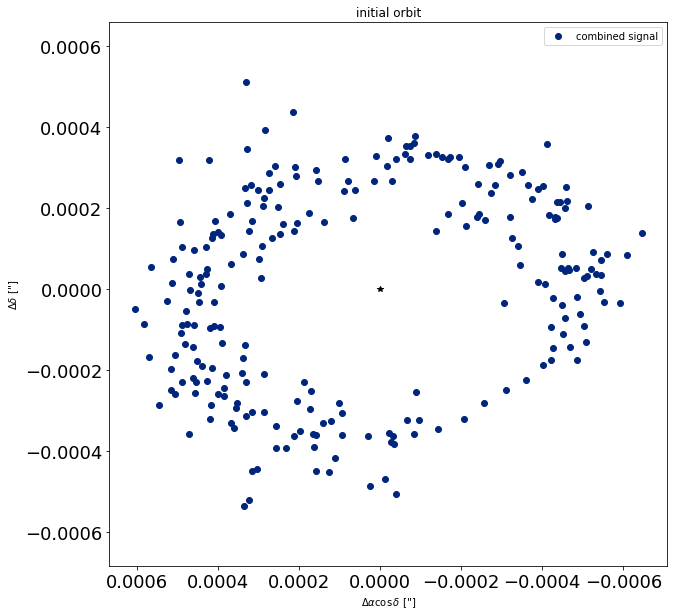

In [5]:
plot_astrometry_signal(
    2, 
    ra_orbit, 
    ra_orbit_sum, 
    ra_sim, 
    ra_sim_sum, 
    dec_orbit, 
    dec_orbit_sum, 
    dec_sim, 
    dec_sim_sum,
    times_astrometry,
    times_observed_astrometry,
    ['#366537', '#db372b', '#00257c'],
    ['Earth', 'Jupiter'])

In [6]:
x_rv = np.array(times_observed_rv)
y_rv = rv_sim_sum
y_rv_err = np.full(np.shape(y_rv), sigma_rv)

x_astrometry = np.array(times_observed_astrometry)
ra_data = ra_sim_sum
ra_err = np.full(np.shape(ra_data), sigma_ra)
dec_data = dec_sim_sum
dec_err = np.full(np.shape(dec_data), sigma_dec)


# make a fine grid that spans the observation window for plotting purposes
t_astrometry = np.linspace(x_astrometry.min() - 5, x_astrometry.max() + 5, 1000)
t_rv = np.linspace(x_rv.min() - 5, x_rv.max() + 5, 1000)

# for predicted orbits
t_fine = np.linspace(x_astrometry.min() - 500, x_astrometry.max() + 500, num=1000)





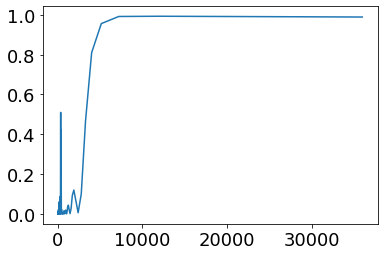

11996.66666666667
336.35514018691595


In [6]:
from astropy.timeseries import LombScargle
frequency, power = LombScargle(x_rv, y_rv).autopower()
period = 1/frequency


period_cut1 = period[period > 10]
power_cut1 = power[period > 10]

plt.plot(period_cut1, power_cut1) 
#plt.xlim(0,500)
plt.show()


indices = power_cut1.argsort()[-1:][::-1]
period1 = np.array(period_cut1[indices][0])
print(period1)

period1_min_cut = 500
#period_cut1 > period1_min_cut so we don't double count

period_cut2 = period_cut1[period_cut1 < period1_min_cut]

power_cut2 = power_cut1[period_cut1 < period1_min_cut]


indices = power_cut2.argsort()[-1:][::-1]
period2 = period_cut2[indices][0]
print(period2)



[ 0.01909199 11.84629745]
minimizing RV only model solutions pre-MCMC
------------


optimizing logp for variables: [tperi]


message: Optimization terminated successfully.
logp: -22767.818455465895 -> -1339.6559430996494
optimizing logp for variables: [logP]


message: Desired error not necessarily achieved due to precision loss.
logp: -1339.6559430996494 -> -1330.4648051649547
optimizing logp for variables: [ecs]


message: Desired error not necessarily achieved due to precision loss.
logp: -1330.4648051649547 -> -1321.6562137580208
optimizing logp for variables: [logs, ecs, logK, tperi, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: -1321.6562137580208 -> -488.85425685420137
<ipython-input-7-5ffdb6315e36>:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax[0].plot(t_rv, rv_map_soln["rv_model_pred"], "b", label="combined model", zorder=2, color = '#773f6a')


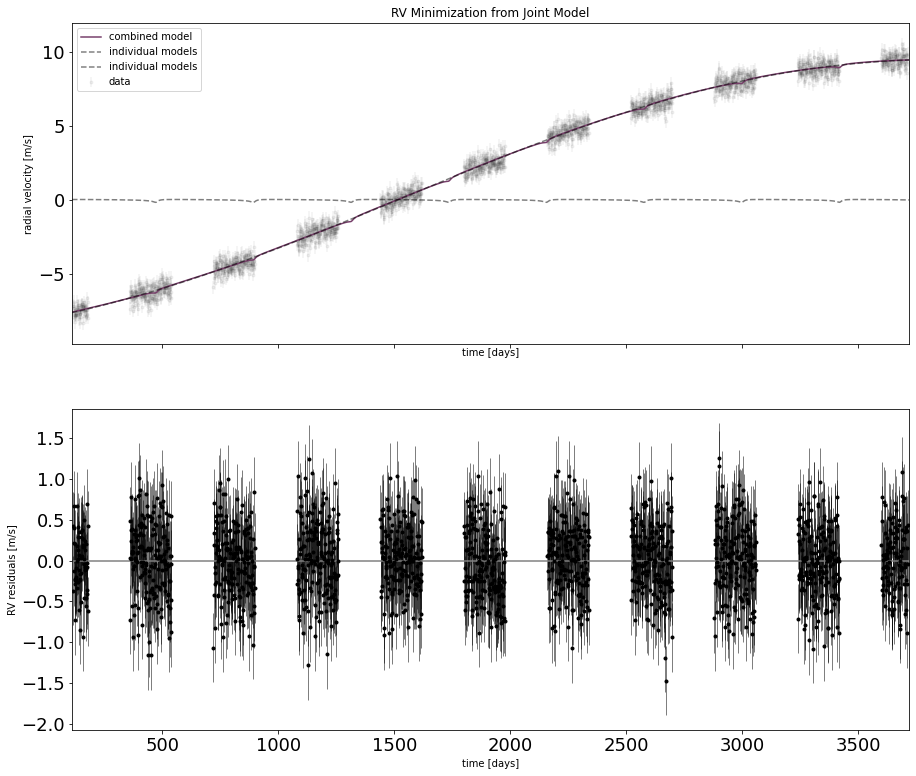

In [7]:
ekw = dict(fmt=".k", lw=0.5)

periods_guess = [period2, period1]
#periods_guess = [P_earth, P_jup]

Ks_guess = xo.estimate_semi_amplitude(periods_guess, x_rv, y_rv, y_rv_err)
print(Ks_guess)

rv_map_soln = minimize_rv(periods_guess, Ks_guess, x_rv, y_rv, y_rv_err)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize = [15,13])

tot_rv_err = np.sqrt(y_rv_err ** 2 + np.exp(2 * rv_map_soln["logs"]))

ax[0].errorbar(x_rv, y_rv, yerr=tot_rv_err, fmt=".k", alpha = 0.05, label='data', zorder=1)
ax[0].plot(t_rv, rv_map_soln["rv_model_pred"], "b", label="combined model", zorder=2, color = '#773f6a')
ax[0].plot(t_rv, rv_map_soln["vrad_pred"], "--k", alpha=0.5, label="individual models")

ax[0].legend(fontsize=10)
ax[0].set_xlim(t_rv.min(), t_rv.max())
ax[0].set_xlabel("time [days]")
ax[0].set_ylabel("radial velocity [m/s]")
ax[0].set_title("RV Minimization from Joint Model")


ax[1].axhline(0.0, color="0.5")
ax[1].errorbar(
    x_rv, y_rv - rv_map_soln["rv_model"], yerr=tot_rv_err, **ekw
)
ax[1].set_xlabel("time [days]")
ax[1].set_ylabel("RV residuals [m/s]")


plt.show()



In [8]:
np.log(1.18698841e+01)

2.4740044444627025

In [9]:
parallax = 0.1 # arcsec
model, map_soln, logp = minimize_both(
    rv_map_soln, x_rv, y_rv, y_rv_err, x_astrometry, 
    ra_data, ra_err, dec_data, dec_err, parallax
)



RV Solutions
------------
P:  [  421.06678641 10371.82438382]
K:  [0.09627727 9.40465732]
T_peri:  [7211.41159992 1706.68075701]
eccentricity:  [0.75641103 0.06444207]
omega:  [-2.61500673 -1.44555708]

minimizing joint model solutions pre-MCMC
------------

trying inclination = 10.0
------------


optimizing logp for variables: [phase, ecs, sqrtm_sini, sqrtm_cosi, Omega_plus, Omega_minus]


message: Optimization terminated successfully.
logp: -1186481.597580396 -> 1597.933729448147
optimizing logp for variables: [log_rv, log_ra_s, log_dec_s, sqrtm_cosi, sqrtm_sini, phase, Omega_minus, Omega_plus, ecs, logP, m_plx]


message: Desired error not necessarily achieved due to precision loss.
logp: 1597.933729448147 -> 1613.0159591053225


log likelihood = 1613.0199999999995

trying inclination = 45.0
------------


optimizing logp for variables: [phase, ecs, sqrtm_sini, sqrtm_cosi, Omega_plus, Omega_minus]


message: Desired error not necessarily achieved due to precision loss.
logp: -61374.06918506684 -> 1611.229230747515
optimizing logp for variables: [log_rv, log_ra_s, log_dec_s, sqrtm_cosi, sqrtm_sini, phase, Omega_minus, Omega_plus, ecs, logP, m_plx]


message: Desired error not necessarily achieved due to precision loss.
logp: 1611.229230747515 -> 1624.6317419561665


log likelihood = 1624.63

trying inclination = 80.0
------------


optimizing logp for variables: [phase, ecs, sqrtm_sini, sqrtm_cosi, Omega_plus, Omega_minus]


message: Desired error not necessarily achieved due to precision loss.
logp: -23998.298503889593 -> 1608.998409350771
optimizing logp for variables: [log_rv, log_ra_s, log_dec_s, sqrtm_cosi, sqrtm_sini, phase, Omega_minus, Omega_plus, ecs, logP, m_plx]


message: Desired error not necessarily achieved due to precision loss.
logp: 1608.998409350771 -> 1625.9774878346088


log likelihood = 1625.96


In [10]:
print(logp)


1625.96


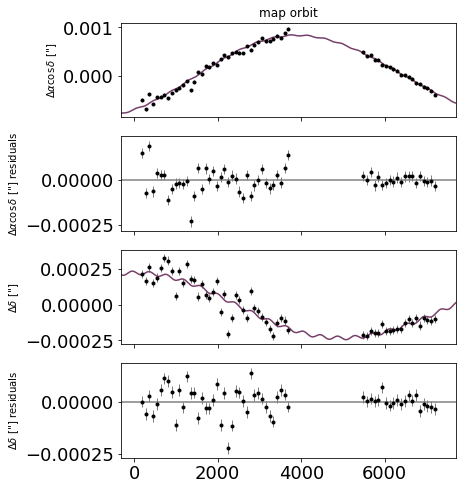

In [11]:

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(6, 8))
ax[0].set_ylabel(r"$\Delta \alpha \cos \delta$ ['']")
ax[1].set_ylabel(r"$\Delta \alpha \cos \delta$ [''] residuals")
ax[2].set_ylabel(r"$\Delta \delta$ ['']")
ax[3].set_ylabel(r"$\Delta \delta$ [''] residuals")


tot_ra_err = np.sqrt(ra_err ** 2 + np.exp(2 * map_soln["log_ra_s"]))
tot_dec_err = np.sqrt(dec_err ** 2 + np.exp(2 * map_soln["log_dec_s"]))

ax[0].errorbar(x_astrometry, ra_data, yerr=tot_ra_err, **ekw)
ax[0].plot(t_fine, map_soln["ra_model_fine"], color="#773f6a")

ax[1].axhline(0.0, color="0.5")
ax[1].errorbar(
    x_astrometry, ra_data - map_soln["ra_model"], yerr=tot_ra_err, **ekw
)


ax[2].plot(t_fine, map_soln["dec_model_fine"], color="#773f6a")
ax[2].errorbar(x_astrometry, dec_data, yerr=tot_dec_err, **ekw)

ax[3].axhline(0.0, color="0.5")
ax[3].errorbar(
    x_astrometry, dec_data - map_soln["dec_model"], yerr=tot_dec_err, **ekw
)

ax[3].set_xlim(t_fine[0], t_fine[-1])
_ = ax[0].set_title("map orbit")

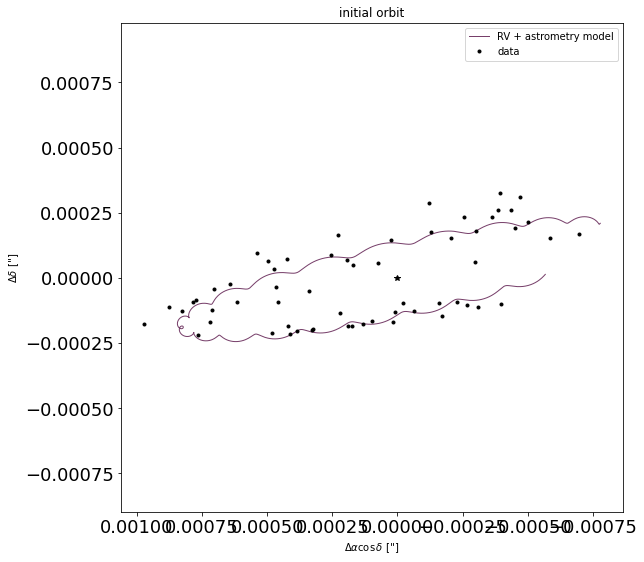

In [12]:
fig, ax = plt.subplots(1, figsize = [9,9])
ax.plot(map_soln["ra_model_fine"], map_soln["dec_model_fine"], 
        color="#773f6a", lw=1, label = "RV + astrometry model")


# plot the data
ax.plot(ra_data, dec_data, ".k", label = "data")

ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")
ax.set_title("initial orbit")
ax.legend()
plt.show()

<ipython-input-13-1ab3a5518fd6>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax[0].plot(t_rv, map_soln["rv_model_pred"], "b", label="combined model", zorder=2, color = '#773f6a')


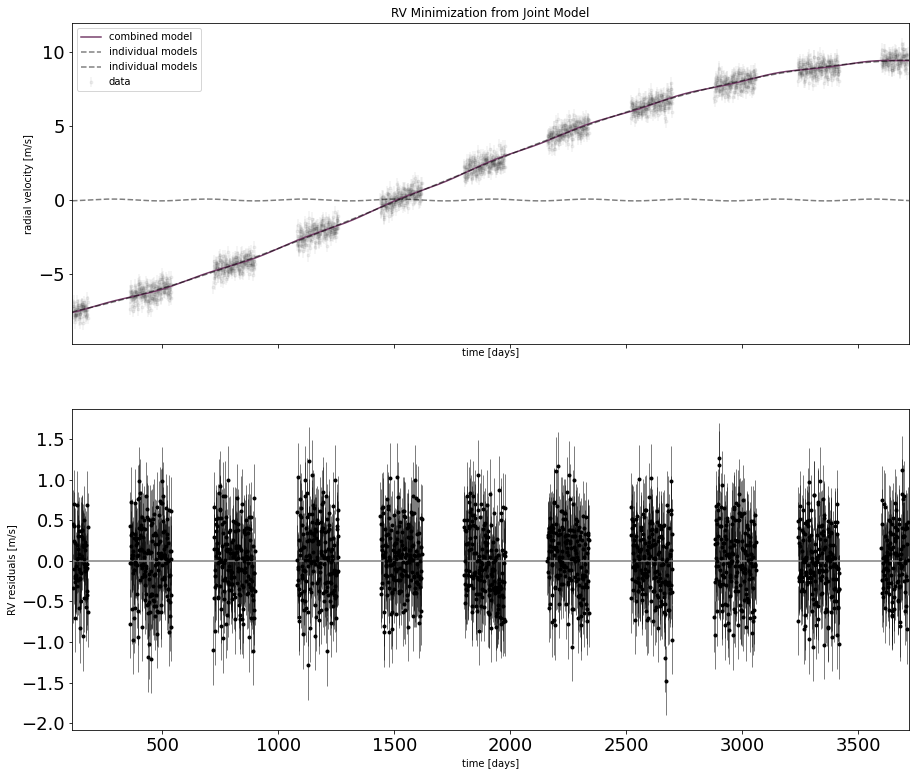

In [13]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize = [15,13])

tot_rv_err = np.sqrt(y_rv_err ** 2 + np.exp(2 * map_soln["log_rv"]))

ax[0].errorbar(x_rv, y_rv, yerr=tot_rv_err, fmt=".k", alpha = 0.05, label='data', zorder=1)
ax[0].plot(t_rv, map_soln["rv_model_pred"], "b", label="combined model", zorder=2, color = '#773f6a')
ax[0].plot(t_rv, map_soln["vrad_pred"], "--k", alpha=0.5, label="individual models")

ax[0].legend(fontsize=10)
ax[0].set_xlim(t_rv.min(), t_rv.max())
ax[0].set_xlabel("time [days]")
ax[0].set_ylabel("radial velocity [m/s]")
ax[0].set_title("RV Minimization from Joint Model")


ax[1].axhline(0.0, color="0.5")
ax[1].errorbar(
    x_rv, y_rv - map_soln["rv_model"], yerr=tot_rv_err, **ekw
)
ax[1].set_xlabel("time [days]")
ax[1].set_ylabel("RV residuals [m/s]")


plt.show()

In [14]:
print(map_soln['m_planet'])
print(map_soln['incl'])
print(map_soln['Omega'])
print(map_soln['tperi'])
print(map_soln['P'])
print(map_soln['ecc'])
print(map_soln['omega'])


[ 39.14007929 319.43330734]
[0.01816314 1.41354744]
[-1.16438979 -4.49825331]
[ 167.97058821 1892.9098501 ]
[  410.17991887 10184.33229676]
[3.64833153e-14 6.19716822e-02]
[-1.77253416 -1.32486014]


In [15]:
print([m_earth*m_sun, m_jup*m_sun])
print([inclination_earth, inclination_jup])
print([Omega_earth, Omega_jup])
print([Tper_earth, Tper_jup])
print([P_earth, P_jup])
print([e_earth, e_jup])
print([omega_earth, omega_jup])


[0.9999991719, 317.829736804977]
[1.3962634015954636, 1.4191272147965892]
[0.0, 1.7523105690023069]
[115.52083329996094, 1633.721527799964]
[365.256, 10000]
[0.0167, 0.0484]
[1.7959438003021653, -1.4957471689591397]


In [54]:
np.random.seed(1234)
with model:
    trace = pmx.sample(
        tune=1000,
        draws=1000,
        start=map_soln,
        cores=2,
        chains=2,
        target_accept=0.95,
        return_inferencedata=True,
    )

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_rv, log_ra_s, log_dec_s, sqrtm_cosi, sqrtm_sini, phase, Omega_minus, Omega_plus, ecs, logP, m_plx]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 424 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [76]:

with open('./traces/period4327_inc45_gaia60_roman5.pkl', 'wb') as buff:
    pickle.dump({'model': model, 'trace': trace}, buff)

In [7]:

with open('./traces/Sep15/period4327_inc45_gaia60_roman5.pkl', 'rb') as buff:
    data = pickle.load(buff)  

model, trace = data['model'], data['trace']

In [8]:
import arviz as az

az.summary(
    trace,
    var_names=["P", "tperi", "omega", "Omega_sum", "Omega_plus", "Omega_minus", 
               "incl", "ecc", "plx", "m_planet", "a"],
)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
P[0],368.377,5.751,358.365,374.804,3.191,2.499,3.0,18.0,1.71
P[1],4315.261,17.289,4285.961,4335.420,11.754,9.794,2.0,12.0,2.37
tperi[0],76.929,112.210,-138.366,184.237,62.451,48.908,4.0,24.0,1.62
tperi[1],1380.390,335.477,602.269,1632.579,218.251,185.219,3.0,11.0,2.27
omega[0],0.355,1.716,-2.882,2.941,0.375,0.834,22.0,32.0,1.74
omega[1],-1.763,0.765,-3.004,-1.494,0.192,0.399,3.0,12.0,1.70
Omega_sum[0],1.449,0.699,0.079,2.633,0.204,0.148,14.0,84.0,1.52
Omega_plus[0],-1.770,1.847,-3.102,2.887,0.414,0.894,17.0,84.0,1.61
Omega_minus[0],1.912,0.459,0.986,2.508,0.265,0.226,3.0,13.0,1.87
incl[0],0.105,0.165,0.000,0.455,0.079,0.060,3.0,23.0,1.89


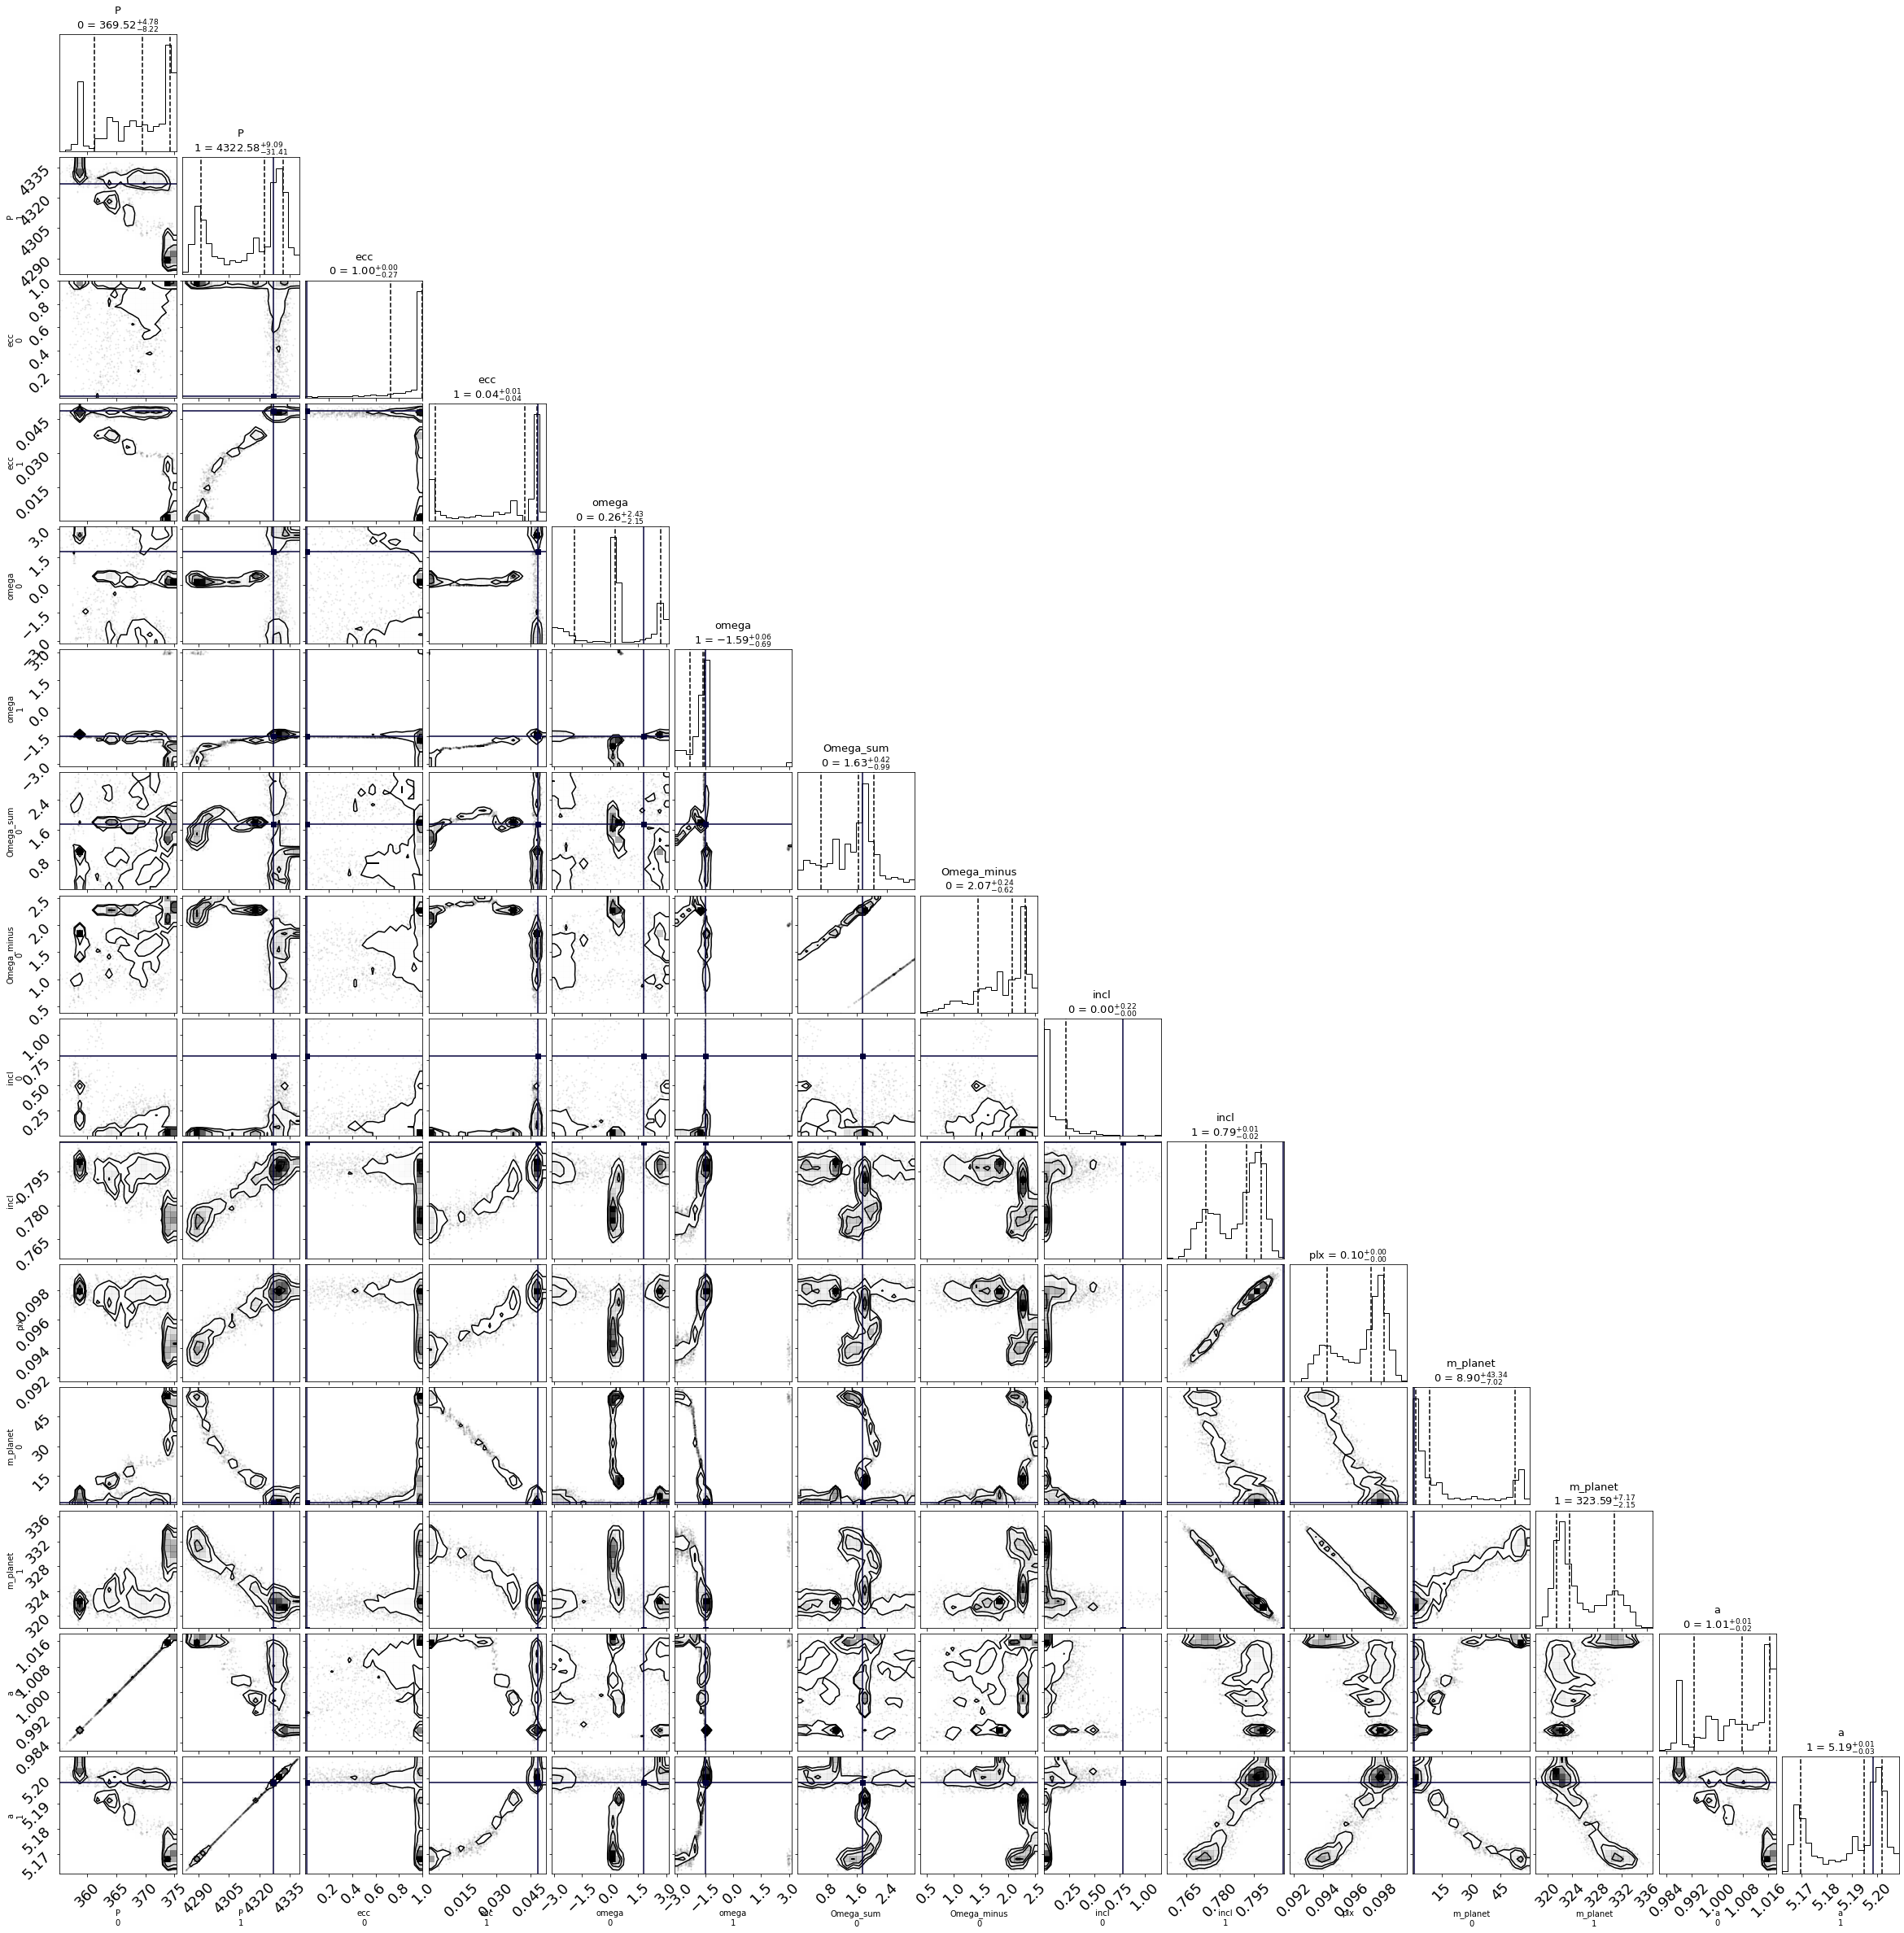

In [9]:
a_true_earth = a_from_Kepler3(P_earth, 1.0+m_earth)
a_true_jup = a_from_Kepler3(P_jup, 1.0+m_jup)

truth_both = [P_earth, P_jup, e_earth, e_jup, omega_earth, omega_jup, Omega_earth+Omega_jup, Omega_earth-Omega_jup, 
              inclination_earth, inclination_jup, 0.1, m_earth*m_sun, m_jup*m_sun, a_true_earth, a_true_jup]


import corner

_ = corner.corner(
    trace, var_names=["P", "ecc", "omega", "Omega_sum", "Omega_minus", "incl", 
                      "plx", "m_planet", "a"], quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 13}, 
                       truths = truth_both, truth_color = "#03003a"
)

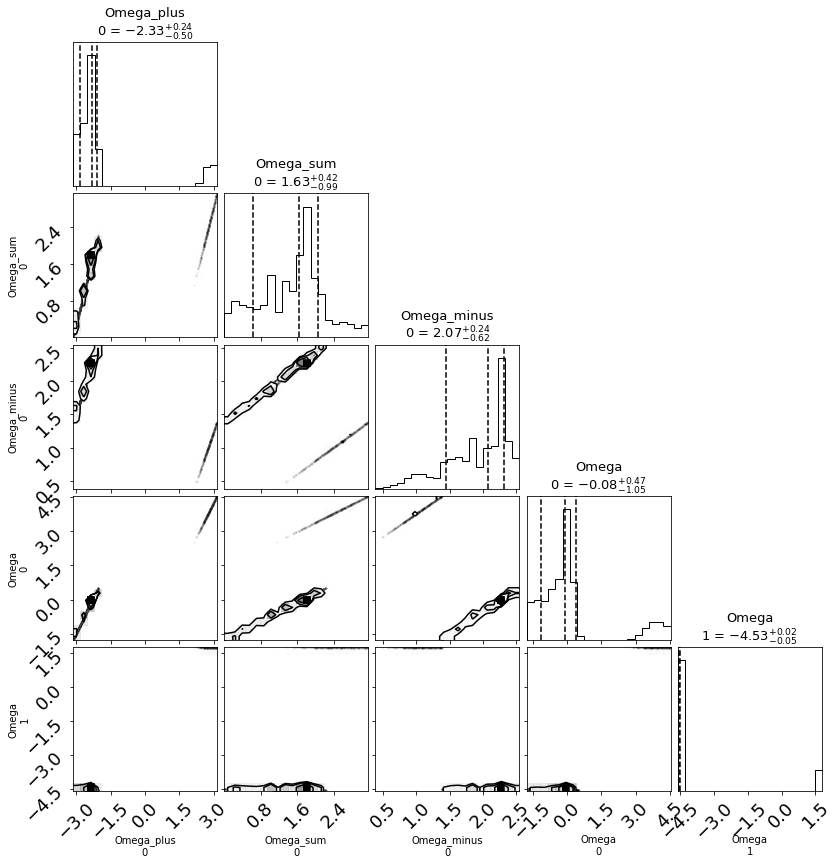

In [10]:
import corner

_ = corner.corner(
    trace, var_names=["Omega_plus", "Omega_sum", "Omega_minus", "Omega"], quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 13}
)

[5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06
 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06
 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06
 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06
 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06
 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06
 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06
 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06
 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06
 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06
 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06
 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06
 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06
 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06 5.e-06
 5.e-0

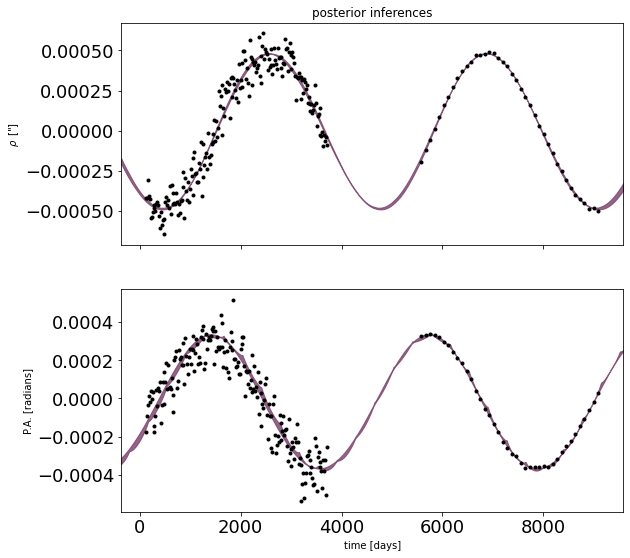

In [11]:
ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(9, 9))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r"P.A. [radians]")
ax[1].set_xlabel(r"time [days]")
print(ra_err)
print(dec_err)
tot_ra_err = ra_err 
tot_dec_err = dec_err 

ax[0].errorbar(x_astrometry, ra_data, yerr=tot_ra_err, **ekw)
q = np.percentile(trace.posterior["ra_model_fine"].values, [16, 84], axis=(0, 1))
ax[0].fill_between(t_fine, q[0], q[1], color="#773f6a", alpha=0.8, lw=1)

ax[1].errorbar(x_astrometry, dec_data, yerr=tot_dec_err, **ekw)
q = np.percentile(trace.posterior["dec_model_fine"].values, [16, 84], axis=(0, 1))
ax[1].fill_between(t_fine, q[0], q[1], color="#773f6a", alpha=0.8, lw=1)

ax[-1].set_xlim(t_fine[0], t_fine[-1])
_ = ax[0].set_title("posterior inferences")

Text(0.5, 1.0, 'MCMC posterior and data')

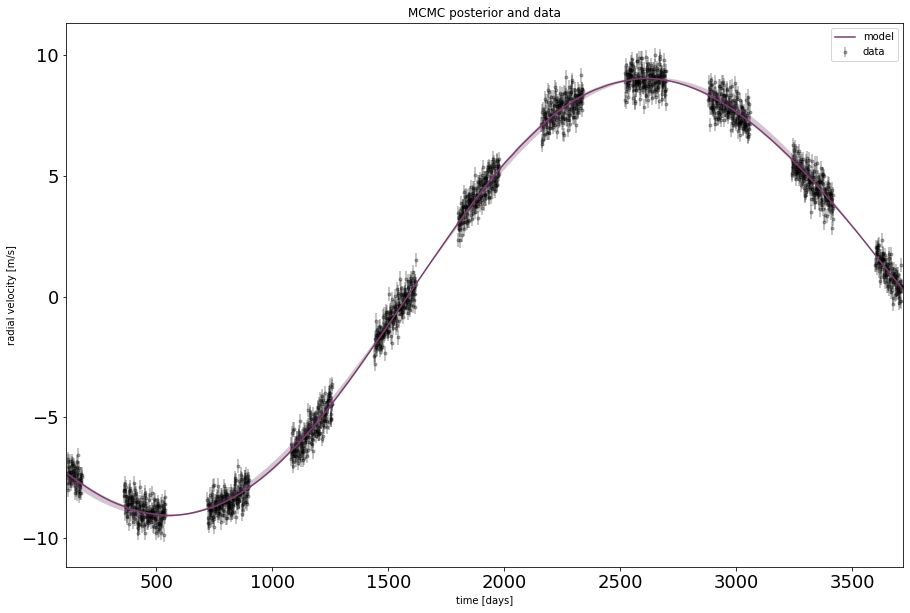

In [12]:
# Compute the posterior predictions for the RV model
rv_pred = trace.posterior["rv_model_pred"].values
pred = np.percentile(rv_pred, [16, 50, 84], axis=(0, 1))

fig, ax = plt.subplots(1, figsize = [15,10], sharey=True)

ax.errorbar(x_rv, y_rv, yerr=y_rv_err, fmt=".k", alpha = 0.3, label='data', zorder = 0)
ax.plot(t_rv, pred[1], color="#773f6a", label="model", zorder = 1)
art = ax.fill_between(t_rv, pred[0], pred[2], color="#773f6a", alpha=0.3)
art.set_edgecolor("none")

ax.legend(fontsize=10)
ax.set_xlim(t_rv.min(), t_rv.max())
ax.set_xlabel("time [days]")
ax.set_ylabel("radial velocity [m/s]")
ax.set_title("MCMC posterior and data")





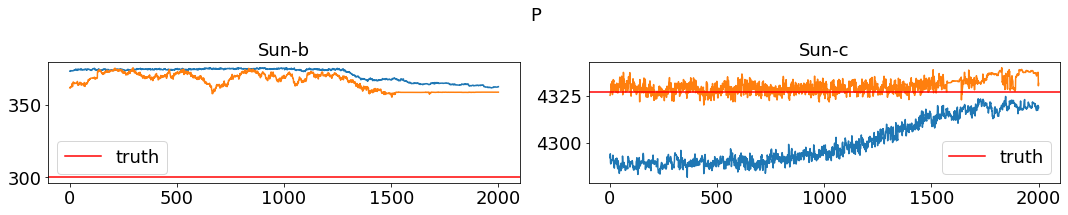

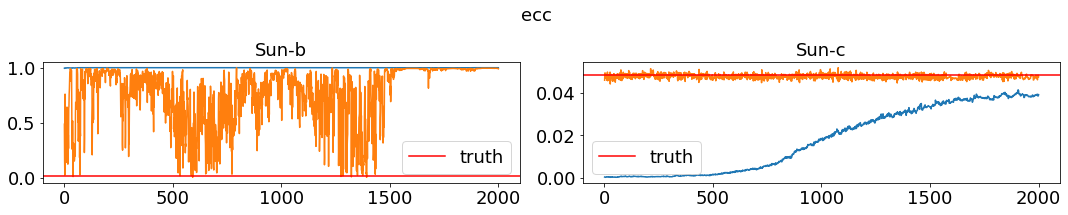

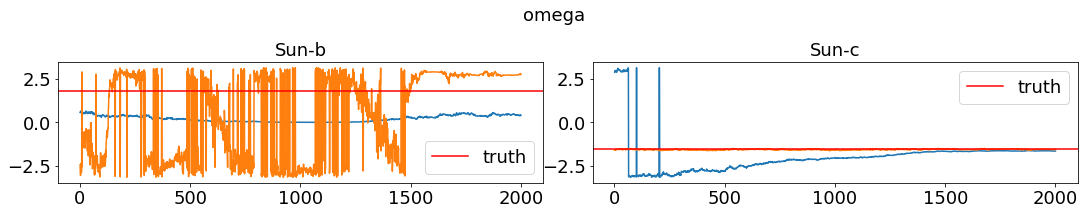

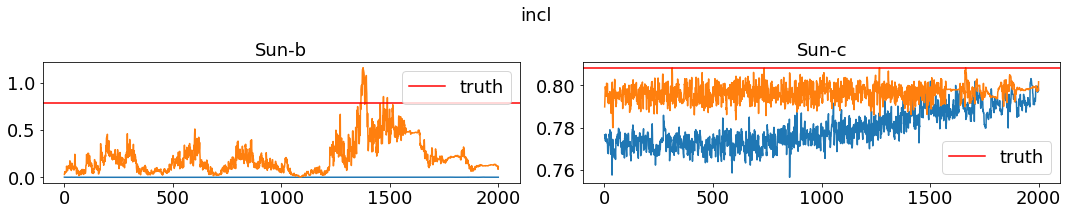

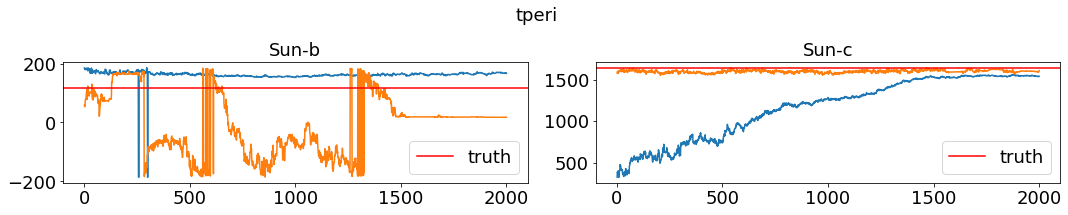

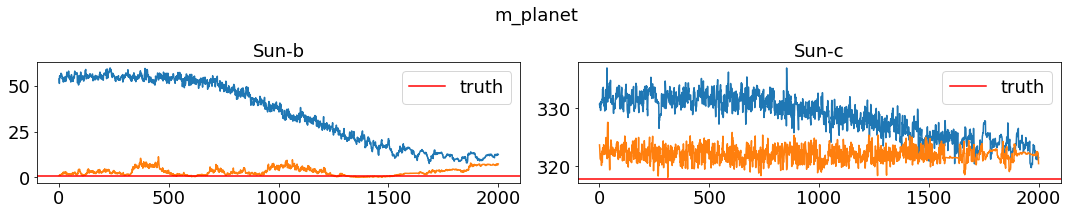

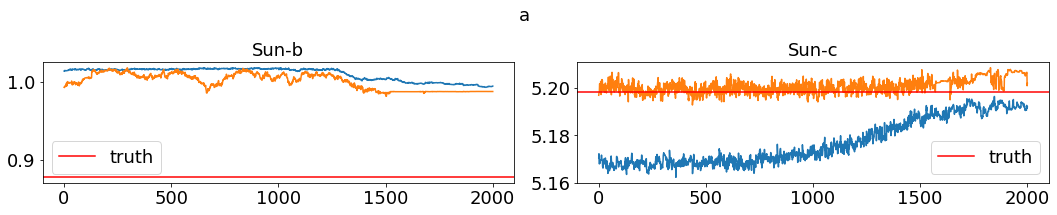

In [13]:
parameters = ["P", "ecc", "omega", "incl", "tperi", "m_planet", "a"]
truth_chain_plot = [P_earth, P_jup, e_earth, e_jup, omega_earth, omega_jup, inclination_earth, inclination_jup, Tper_earth, Tper_jup, m_earth*m_sun, m_jup*m_sun, a_true_earth, a_true_jup]

for ii in range(0, len(parameters)):
    plot_truth = False
    param = parameters[ii]
    
    true_vals_earth = truth_chain_plot[2*ii]
    true_vals_jup = truth_chain_plot[2*ii+1]
    plot_truth = True
    
    fig, ax = plt.subplots(1,2, figsize = (15,3))
    planet1_chain1 = trace.posterior[param].values[:, :, 0][0]
    planet1_chain2 = trace.posterior[param].values[:, :, 0][1]
    
    planet2_chain1 = trace.posterior[param].values[:, :, 1][0]
    planet2_chain2 = trace.posterior[param].values[:, :, 1][1]
    
    
    nstep = np.arange(1, len(planet1_chain1)+1, 1)
    
    
    ax[0].plot(nstep, planet1_chain1)
    ax[0].plot(nstep, planet1_chain2)
    
    if plot_truth:
        ax[0].axhline(y=true_vals_earth, color = 'r', label = 'truth')
    ax[0].set_title("Sun-b", fontsize = 18)
    ax[0].legend(fontsize = 18)
    
    ax[1].plot(nstep, planet2_chain1)
    ax[1].plot(nstep, planet2_chain2)
    
    if plot_truth:
        ax[1].axhline(y=true_vals_jup, color = 'r', label = 'truth')
    ax[1].set_title("Sun-c", fontsize = 18)
    ax[1].legend(fontsize = 18)

    fig.suptitle(param, fontsize = 18)
    fig.tight_layout()
    plt.show()

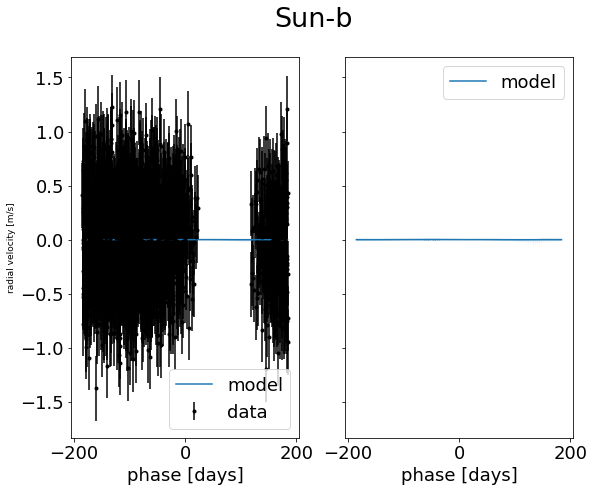

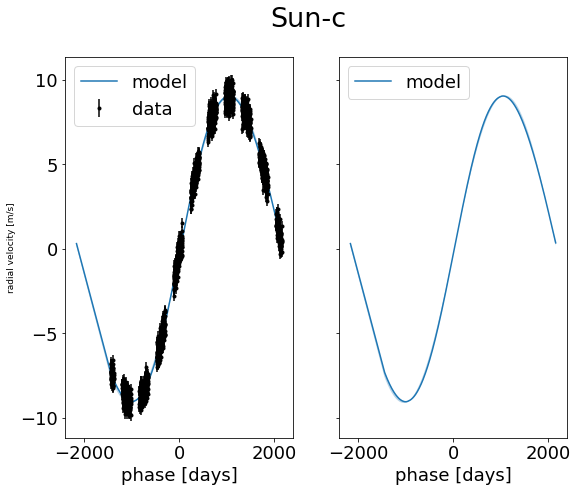

In [16]:
for n, letter in enumerate("bc"):
    fig, ax = plt.subplots(1,2, figsize = [9,7], sharey=True)
    ax0, ax1 = ax[0], ax[1]
    
    # Get the posterior median orbital parameters
    p = np.median(trace.posterior["P"].values[:, :, n])
    t0 = np.median(trace.posterior["tperi"].values[:, :, n])

    # Compute the median of posterior estimate the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(
        trace.posterior["vrad"].values[:, :, :, (n + 1) % 2], axis=(0, 1)
    )

    # Plot the folded data
    x_fold = (x_rv - t0 + 0.5 * p) % p - 0.5 * p
    ax0.errorbar(x_fold, y_rv - other, yerr=y_rv_err, fmt=".k", label = "data")

    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t_rv - t0 + 0.5 * p) % p - 0.5 * p
    inds = np.argsort(t_fold)
    pred = np.percentile(
        trace.posterior["vrad_pred"].values[:, :, inds, n],
        [16, 50, 84],
        axis=(0, 1),
    )
    ax0.plot(t_fold[inds], pred[1], color="C0", label="model")
    art = ax0.fill_between(
        t_fold[inds], pred[0], pred[2], color="C0", alpha=0.3
    )
    art.set_edgecolor("none")
    
    
    
    
    
    
    ax1.plot(t_fold[inds], pred[1], color="C0", label="model")
    art = ax1.fill_between(
        t_fold[inds], pred[0], pred[2], color="C0", alpha=0.3
    )
    art.set_edgecolor("none")

    ax0.legend(fontsize=18)
    ax1.legend(fontsize=18)
    plt.xlim(-0.5 * p, 0.5 * p)
    ax0.set_xlabel("phase [days]", fontsize=18)
    ax1.set_xlabel("phase [days]", fontsize=18)
    ax0.set_ylabel("radial velocity [m/s]", fontsize=9)
    ax0.set_ylabel("radial velocity [m/s]", fontsize=9)
    ax0.set_xlim(-p/1.8, p/1.8)
    ax1.set_xlim(-p/1.8, p/1.8)
    fig.suptitle("Sun-{0}".format(letter), fontsize=27)

In [17]:
def get_star_relative_angles(orbit, t, parallax):
    
    X, Y, Z = orbit.get_star_position(t, parallax)

    # calculate rho and theta
    rho = tt.squeeze(tt.sqrt(X ** 2 + Y ** 2))  # arcsec
    theta = tt.squeeze(tt.arctan2(Y, X))  # radians between [-pi, pi]

    return (rho, theta)

In [18]:
p_earth=365.256
t = np.linspace(0, 1000, 1000)
m_earth = 1.*3.00273e-6 #units m_sun
orbit_earth = xo.orbits.KeplerianOrbit(
    m_star=1.,
    r_star=1.,
    t0=0.5,
    period=p_earth,
    ecc=0.0167,
    omega=np.radians(102.9),
    Omega=np.radians(0.0),
    incl=np.radians(45.0),
    m_planet=m_earth,
)


rho_star_earth, theta_star_earth = theano.function([], get_star_relative_angles(orbit_earth, t, parallax=0.1))()
rho_earth, theta_earth = theano.function([], orbit_earth.get_relative_angles(t, parallax=0.1))()

rho_star_earth_diff = np.max(rho_star_earth) - np.min(rho_star_earth)
rho_earth_diff = np.max(rho_earth)- np.min(rho_earth)

In [19]:
p_jup=4327.631
t = np.linspace(0, 10000, 10000)
m_jup = 317.83*3.00273e-6 #units m_sun
orbit_jup = xo.orbits.KeplerianOrbit(
    m_star=1.,
    r_star=1.,
    t0=2000,
    period=p_jup,
    ecc=0.0484,
    omega=np.radians(274.3) - 2*np.pi,
    Omega=np.radians(100.4),
    incl=np.radians(45.0),
    m_planet=m_jup,
)


rho_star_jup, theta_star_jup = theano.function([], get_star_relative_angles(orbit_jup, t, parallax=0.1))()
rho_jup, theta_jup = theano.function([], orbit_jup.get_relative_angles(t, parallax=0.1))()

rho_star_jup_diff = np.max(rho_star_jup) - np.min(rho_star_jup)
rho_jup_diff = np.max(rho_jup)- np.min(rho_jup)

In [20]:
#make sure amplitude of separation is correct for star and planet motion
assert np.isclose(rho_earth_diff, 3.0813126e-02)
assert np.isclose(rho_star_earth_diff, 9.2523221e-08)


#make sure planet and star position angle closely mirrors each other
assert np.allclose(theta_earth[:int(p_earth/2)], theta_star_earth[int(p_earth/2):int(p_earth)-1], atol=0.2)





#make sure amplitude of separation is correct for star and planet motion
assert np.isclose(rho_jup_diff, 1.7190731e-01)
assert np.isclose(rho_star_jup_diff, 1.6390463e-04)


#make sure planet and star position angle closely mirrors each other
assert np.allclose(theta_jup[:int(p_jup/2)], theta_star_jup[int(p_jup/2):int(p_jup)-1], atol=0.2)